# Parallel Programming
# Homework 5 | 05/19/20
This notebook evaluates the execution performances of running twitter.go in parallel versus sequentially

In [8]:
import math
import subprocess
import sys
import os
import timeit
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Define input variables:

$P$ = total number of operations being processed for one program execution

$N$ = number of threads

$B = ceil(P/N)$ = block size per thread

In [18]:
P = [50000, 100000, 500000, 1000000]
N = [1,2,4,6,8]
data_filenames = ["50k", "100k", "500k", "1m"]

In [16]:
#generate our data
def generate_data(data_filenames, P, perc_add, perc_remove, perc_contains, perc_feed):
    filepath = r"C:\Users\eddie\Documents\MSCS\ParallelProgramming\eddieshim\hw5"
    for i in range(0, len(P)):
        data_filename = data_filenames[i]
        num_tasks = P[i]
        args = "{} {} {} {} {}".format(num_tasks, perc_add, perc_remove, perc_contains, perc_feed)
        command = "go run {}\\generate.go {} > {}\\{}.txt".format(filepath, args, filepath,data_filename)
        p = subprocess.Popen(["powershell.exe", command])
    
generate_data(data_filenames, P, 50, 49, 1, 0)

In [10]:
#function that uses Windows Powershell terminal in order to execute our twitter.go script in parallel or serial
def run_twitter(data_filename, numThreads, blockSize):
    filepath_data = "C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\hw5"
    filepath_twitter = "C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\proj1\\twitter"
    filepath_out = "C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\hw5\\output_seq_{}.txt".format(data_filename)
    args = ""
    
    if numThreads and blockSize: 
        args = "{} {}".format(numThreads, blockSize)        
        filepath_out = "C:\\Users\\eddie\\Documents\\MSCS\\ParallelProgramming\\eddieshim\\hw5\\output_parallel_{}.txt".format(data_filename)
        
    command = "Get-Content {}\\{}.txt | & \"{}\\twitter.exe\" {} > {}.txt".format(filepath_data, data_filename, filepath_twitter, args, filepath_out)
    time_command = "Measure-Command{" +  command + "}  | Select-Object -Property TotalSeconds"
    process = subprocess.Popen(["powershell.exe", time_command], stdout = subprocess.PIPE, stderr = subprocess.STDOUT)
    terminal_output = str(process.communicate()[0])    
    exec_output = round(float(re.findall("\d+\.\d+", terminal_output)[0]), 2)
    return(exec_output)    

Example Windows Powershell terminal command that returns execution time (seconds) of twitter.go:


$$Measure-Command{Get-Content C:\Users\eddie\Documents\MSCS\ParallelProgramming\eddieshim\hw5\10k.txt | & "C:\Users\eddie\Documents\MSCS\ParallelProgramming\eddieshim\proj1\twitter\twitter.exe" }  | Select-Object -Property TotalSeconds$$

In [19]:
#calculate sequential execution times
def calc_avg_seq_times(timing_sample_n, N, P, data_filenames):
    average_sequential_times = []
    for i in range(0, timing_sample_n):
        sequential_times = []
        for i in range(0, len(P)):    
            data_filename = data_filenames[i]
            time = run_twitter(data_filename, None, None)
            print("Processed sequential file: p = {p} | time = {t}".format(p = P[i], t = time))
            sequential_times.append(time)
        average_sequential_times += sequential_times
    return(np.divide(average_sequential_times, timing_sample_n))
    
seq_times = calc_avg_seq_times(5, N, P, data_filenames)
print(seq_times)

Processed sequential file: p = 50000 | time = 9.26
Processed sequential file: p = 100000 | time = 17.74
Processed sequential file: p = 500000 | time = 203.67
Processed sequential file: p = 1000000 | time = 795.75
[  9.26  17.74 203.67 795.75]


In [20]:
#calculate parallel execution times
def calc_avg_parallel_times(timing_sample_n, N, P, data_filenames):
    average_parallel_times = []

    for i in range(0, timing_sample_n):
        parallel_times = []
        for i in range(0,len(P)):
            for n in N:
                b = math.ceil(P[i]/n)
                data_filename = data_filenames[i]
                time = run_twitter(data_filename, n, b)
                print("Processed parallel file: p = {p}, n = {n}, b = {b} | time = {t}".format(p=P[i], n=n, b=b, t=time))
                parallel_times.append(time)
        average_parallel_times += parallel_times
    return(np.divide(average_parallel_times, timing_sample_n))
    
parallel_times = calc_avg_parallel_times(5, N, P, data_filenames)
print(parallel_times)

Processed parallel file: p = 50000, n = 1, b = 50000 | time = 9.77
Processed parallel file: p = 50000, n = 2, b = 25000 | time = 9.58
Processed parallel file: p = 50000, n = 4, b = 12500 | time = 13.51
Processed parallel file: p = 50000, n = 6, b = 8334 | time = 14.77
Processed parallel file: p = 50000, n = 8, b = 6250 | time = 15.13
Processed parallel file: p = 100000, n = 1, b = 100000 | time = 18.81
Processed parallel file: p = 100000, n = 2, b = 50000 | time = 33.07
Processed parallel file: p = 100000, n = 4, b = 25000 | time = 19.79
Processed parallel file: p = 100000, n = 6, b = 16667 | time = 18.51
Processed parallel file: p = 100000, n = 8, b = 12500 | time = 24.38
Processed parallel file: p = 500000, n = 1, b = 500000 | time = 207.05
Processed parallel file: p = 500000, n = 2, b = 250000 | time = 1253.09
Processed parallel file: p = 500000, n = 4, b = 125000 | time = 187.93
Processed parallel file: p = 500000, n = 6, b = 83334 | time = 182.05
Processed parallel file: p = 50000

Defining speed up as:

$$speedup = \frac{\text{wall-clock time of serial execution}}{\text{wall-clock time of parallel execution}}$$

In [21]:
#calcluate speedup times
def calc_speedup(data_filenames, seq_times, parallel_times, N, P):
    speedup = pd.DataFrame(columns = data_filenames)
    index = 0
    for i in range(0,len(P)):
        p_performance = []
        for n in N:
            p_performance.append(np.divide(seq_times[i], parallel_times[index]))
            index += 1
    return(speedup)

speedup = calc_speedup(data_filenames, seq_times, parallel_times, N, P)

In [22]:
speedup_df = pd.DataFrame(columns = data_filenames)
index = 0
for i in range(0,len(P)):
    p_performance = []
    for n in N:
        p_performance.append(np.divide(seq_times[i], parallel_times[index]))
        index += 1
    speedup_df[data_filenames[i]] = p_performance
speedup_df.index = N
speedup_df.index.names = ["numThreads"]
print(speedup_df)
        

                 50k      100k      500k        1m
numThreads                                        
1           0.947799  0.943115  0.983675  0.992108
2           0.966597  0.536438  0.162534  0.888302
4           0.685418  0.896412  1.083755  0.826624
6           0.626947  0.958401  1.118759  0.963168
8           0.612029  0.727646  1.136869  0.945655


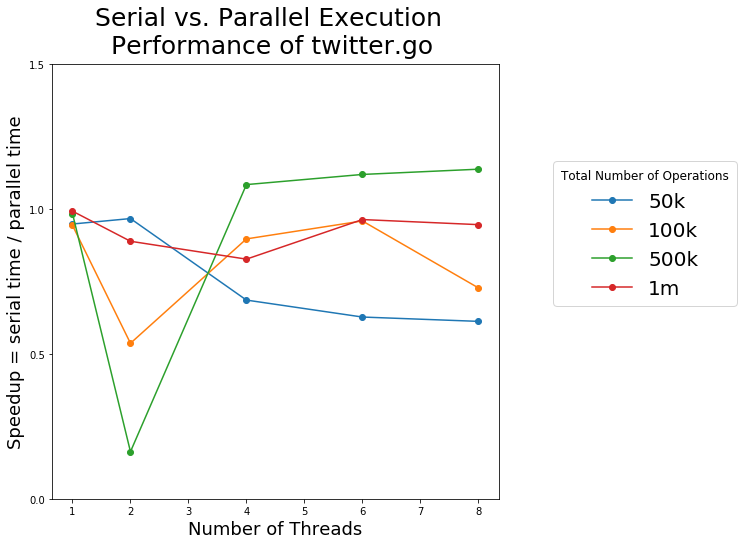

In [26]:
fig, ax = plt.subplots()
plt.plot("50k", data = speedup_df, marker = 'o')
plt.plot("100k", data = speedup_df, marker = 'o')
plt.plot("500k", data = speedup_df, marker = 'o')
plt.plot("1m", data = speedup_df, marker = 'o')
plt.xlabel("Number of Threads", fontsize = 18)
plt.ylabel("Speedup = serial time / parallel time", fontsize = 18)
plt.yticks(np.arange(0, 2, .5))
plt.suptitle("Serial vs. Parallel Execution\n Performance of twitter.go", fontsize = 25)
plt.rcParams["figure.figsize"]=(8,8)
plt.legend(bbox_to_anchor = (1.1,.8), prop = {"size": 20}, title = "Total Number of Operations")
plt.rcParams['legend.title_fontsize'] = 'large'